In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 100
SAMPLE_STEP = 5
MEASUREMENTS_IN_SHUFFLE_GROUP = 300
CSV_FILE_PATH = '../gyroscope_data_updated.csv'

df = pd.read_csv(CSV_FILE_PATH)

In [3]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

def split(samples, train_part_in_percents, val_part_in_percents, test_part_in_percents):
    train_part_end = int(train_part_in_percents * samples.shape[0])
    val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
    test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

    train_data = samples[0:train_part_end]
    val_data = samples[train_part_end:val_part_end]
    test_data = samples[val_part_end:test_part_end]
    
    return train_data, val_data, test_data

train_data_array = []
val_data_array = []
test_data_array = []

def shuffle_groups(l_df):
    number_of_groups = l_df.shape[0] // MEASUREMENTS_IN_SHUFFLE_GROUP 
    size_of_new_df = number_of_groups * MEASUREMENTS_IN_SHUFFLE_GROUP
    
    l_df = l_df[0: size_of_new_df]

    groups = l_df.values.reshape((number_of_groups, MEASUREMENTS_IN_SHUFFLE_GROUP, l_df.shape[-1]))
    
    randomize = np.arange(number_of_groups)
    np.random.shuffle(randomize)
    groups = groups[randomize]
    
    return pd.DataFrame(groups.reshape((size_of_new_df, l_df.shape[-1])), columns=l_df.columns)
    

for label in df['activity_type'].unique():
    l_df = df[df['activity_type'] == label]
    
    train_data, val_data, test_data = split(shuffle_groups(l_df), 0.6, 0.2, 0.2)
    
    train_data_array.append(train_data)
    val_data_array.append(val_data)
    test_data_array.append(test_data)

train_df = pd.concat(train_data_array)
val_df = pd.concat(val_data_array)
test_df = pd.concat(test_data_array)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(45360, 7)
(15120, 7)
(15120, 7)


In [4]:
def preparaSamplesAndTargets(df):
    targets_and_samples = []

    def prepareForOneLabel(label, df):
        l_df = df[df['activity_type'] == label]
        l_df = l_df[l_df.columns[0:-1]]
        samples_number = (l_df.shape[0] - MEASUREMENTS_PER_SAMPLE) // SAMPLE_STEP
    
        def getSample(sample_index):
            sample_start_index = sample_index * SAMPLE_STEP
            sample_end_index = (sample_index * SAMPLE_STEP) + MEASUREMENTS_PER_SAMPLE
        
            return l_df[sample_start_index:sample_end_index].values.reshape(1, MEASUREMENTS_PER_SAMPLE, 6)
    
        return [[label, getSample(sample_index)] for sample_index in range(samples_number)]

    for label in df['activity_type'].unique():
        targets_and_samples.extend(prepareForOneLabel(label, df))

    samples = np.concatenate([ts[1] for ts in targets_and_samples])
    targets = LabelBinarizer().fit_transform(np.array([ts[0] for ts in targets_and_samples]))
    
    return samples, targets

train_data, train_labels = preparaSamplesAndTargets(train_df)
val_data, val_labels = preparaSamplesAndTargets(val_df)
test_data, test_labels = preparaSamplesAndTargets(test_df)

print(train_data.shape)
print(train_labels.shape)

print(val_data.shape)
print(val_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(8972, 100, 6)
(8972, 5)
(2924, 100, 6)
(2924, 5)
(2924, 100, 6)
(2924, 5)


In [5]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

train_data, train_labels = shuffleSamplesAndTargets(train_data, train_labels)

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [14]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [15]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

%time history = model.fit(train_data, train_labels, epochs=100, callbacks=callbacks, batch_size=64, validation_data=(val_data, val_labels))

Train on 8972 samples, validate on 2924 samples
Epoch 1/100
8972/8972 [==============================] - 2s 199us/step - loss: 0.2505 - acc: 0.3503 - val_loss: 0.2035 - val_acc: 0.4709
Epoch 2/100
8972/8972 [==============================] - 1s 135us/step - loss: 0.1962 - acc: 0.4847 - val_loss: 0.1354 - val_acc: 0.6471
Epoch 3/100
8972/8972 [==============================] - 1s 130us/step - loss: 0.1724 - acc: 0.5488 - val_loss: 0.1334 - val_acc: 0.6491
Epoch 4/100
8972/8972 [==============================] - 1s 131us/step - loss: 0.1566 - acc: 0.5788 - val_loss: 0.1271 - val_acc: 0.6631
Epoch 5/100
8972/8972 [==============================] - 1s 138us/step - loss: 0.1418 - acc: 0.5988 - val_loss: 0.1214 - val_acc: 0.6720
Epoch 6/100
8972/8972 [==============================] - 1s 130us/step - loss: 0.1301 - acc: 0.6088 - val_loss: 0.1142 - val_acc: 0.6618
Epoch 7/100
8972/8972 [==============================] - 1s 139us/step - loss: 0.1190 - acc: 0.6278 - val_loss: 0.1128 - val_acc: 

8972/8972 [==============================] - 1s 139us/step - loss: 0.0093 - acc: 0.9717 - val_loss: 0.0303 - val_acc: 0.9008
Epoch 61/100
8972/8972 [==============================] - 1s 141us/step - loss: 0.0104 - acc: 0.9677 - val_loss: 0.0312 - val_acc: 0.8998
Epoch 62/100
8972/8972 [==============================] - 1s 135us/step - loss: 0.0097 - acc: 0.9709 - val_loss: 0.0352 - val_acc: 0.8875
Epoch 63/100
8972/8972 [==============================] - 1s 135us/step - loss: 0.0099 - acc: 0.9710 - val_loss: 0.0298 - val_acc: 0.9012
Epoch 64/100
8972/8972 [==============================] - 1s 131us/step - loss: 0.0093 - acc: 0.9719 - val_loss: 0.0360 - val_acc: 0.8861
Epoch 65/100
8972/8972 [==============================] - 1s 131us/step - loss: 0.0102 - acc: 0.9671 - val_loss: 0.0311 - val_acc: 0.9025
Epoch 66/100
8972/8972 [==============================] - 1s 130us/step - loss: 0.0092 - acc: 0.9709 - val_loss: 0.0340 - val_acc: 0.8957
Epoch 67/100
8972/8972 [=======================

              acc     val_acc        loss    val_loss
count  100.000000  100.000000  100.000000  100.000000
mean     0.939036    0.861105    0.020836    0.047433
std      0.114792    0.059913    0.040670    0.021779
min      0.393558    0.584815    0.002560    0.032318
25%      0.962773    0.866878    0.003628    0.038061
50%      0.983950    0.879446    0.005483    0.042397
75%      0.989328    0.887226    0.013144    0.045686
max      0.992644    0.904583    0.230273    0.162473


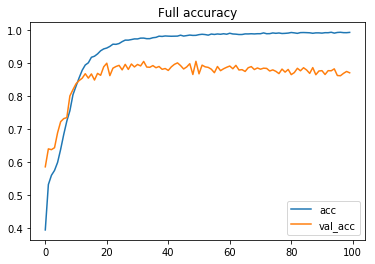

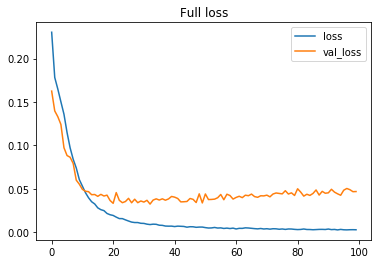

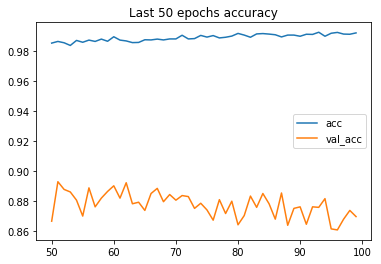

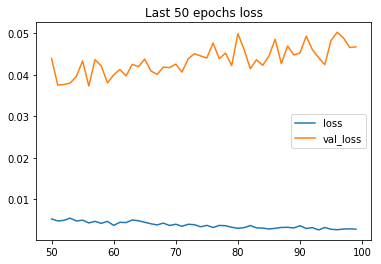

In [9]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [10]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [11]:
best_model.evaluate(test_data, test_labels)

2924/2924 [==============================] - 0s 84us/step


[0.04429094089086613, 0.8703830369357045]

In [12]:
best_model.predict(test_data[0:1])

array([[4.8738749e-11, 2.2094013e-10, 1.7348491e-06, 9.6873030e-13,
        9.9999821e-01]], dtype=float32)